In [1]:
import os
import sys
import argparse
import torch
from getdist import plots, MCSamples
import getdist
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
from scipy.stats import multivariate_normal

In [2]:
path = os.path.realpath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, path)

In [3]:
from nnest.trainer import Trainer
from nnest.likelihoods import *
from nnest.priors import *

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
# Likelihood
#prior = UniformPrior(2, -5, 5)
#like = Himmelblau(2)
#prior = UniformPrior(2, -2, 12)
#like = Rosenbrock(2)
#prior = UniformPrior(2, -5, 5)
#like = Gaussian(2, 0.9)
#prior = UniformPrior(2, -20, 20)
#like = Eggbox(2)
prior = UniformPrior(2, -3, 3)
like = GaussianShell(2)
#prior = UniformPrior(2, -8, 8)
#like = GaussianMix(2)

In [6]:
np.random.seed(0)
samples = like.sample(prior, 1000)

In [7]:
#t = Trainer(like.x_dim, flow='choleksy', learning_rate=0.001)
#t = Trainer(like.x_dim, hidden_dim=64,  num_blocks=5, flow='nvp')
t = Trainer(like.x_dim, hidden_dim=16,  num_blocks=3, flow='spline')

[nnest.trainer] [INFO] SingleSpeedSpline(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): ActNorm()
      (1): Invertible1x1Conv()
      (2): NSF_CL(
        (f1): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): LeakyReLU(negative_slope=0.2)
            (6): Linear(in_features=16, out_features=23, bias=True)
          )
        )
        (f2): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
        

In [8]:
t.train(samples, jitter=0.01, l2norm=0.0)

[nnest.trainer] [INFO] Number of training samples [1000]
[nnest.trainer] [INFO] Training jitter [0.0100]
[nnest.trainer] [INFO] Epoch [1] train loss [0.0362] validation loss [0.0355]
[nnest.trainer] [INFO] Epoch [50] train loss [0.0236] validation loss [0.0244]
[nnest.trainer] [INFO] Epoch [100] train loss [0.0188] validation loss [0.0206]
[nnest.trainer] [INFO] Epoch [150] train loss [0.0181] validation loss [0.0203]
[nnest.trainer] [INFO] Epoch [200] train loss [0.0176] validation loss [0.0201]
[nnest.trainer] [INFO] Epoch [250] train loss [0.0174] validation loss [0.0199]
[nnest.trainer] [INFO] Epoch [300] train loss [0.0172] validation loss [0.0198]
[nnest.trainer] [INFO] Epoch [350] train loss [0.0170] validation loss [0.0197]
[nnest.trainer] [INFO] Epoch [400] train loss [0.0169] validation loss [0.0196]
[nnest.trainer] [INFO] Epoch [450] train loss [0.0168] validation loss [0.0195]
[nnest.trainer] [INFO] Epoch [500] train loss [0.0169] validation loss [0.0195]
[nnest.trainer] [I

In [9]:
x_synth = t.netG.sample(samples.size).detach().cpu().numpy()
z = t.get_latent_samples(samples)

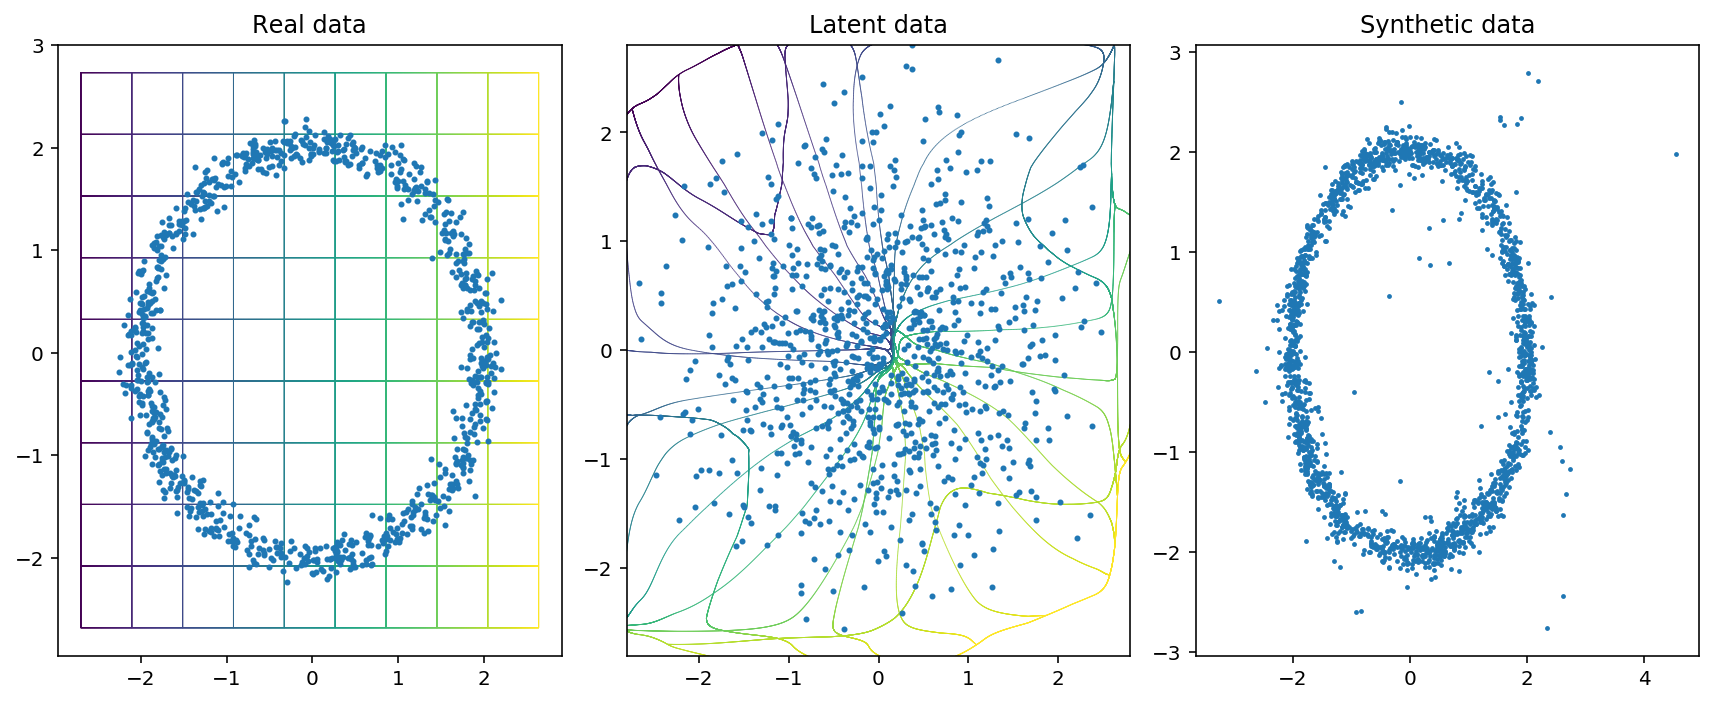

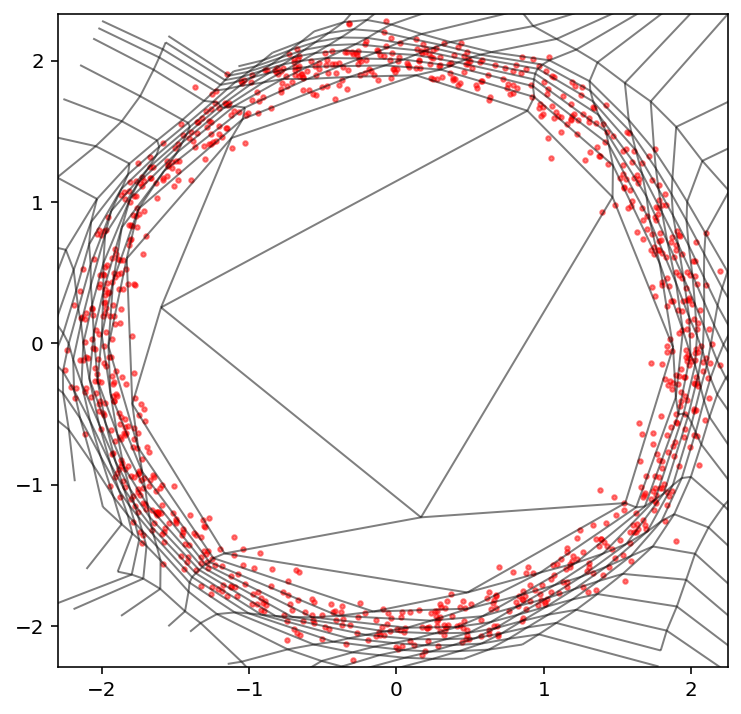

In [10]:
if like.x_dim == 2:
    grid = []
    for x in np.linspace(np.min(samples[:, 0])*1.2, np.max(samples[:, 0])*1.2, 10):
        for y in np.linspace(np.min(samples[:, 1])*1.2, np.max(samples[:, 1])*1.2, 5000):
            grid.append([x, y])
    for y in np.linspace(np.min(samples[:, 1])*1.2, np.max(samples[:, 1])*1.2, 10):
        for x in np.linspace(np.min(samples[:, 0])*1.2, np.max(samples[:, 0])*1.2, 5000):
            grid.append([x, y])
    grid = np.array(grid)
    z_grid = t.get_latent_samples(grid)
    fig, ax = plt.subplots(1, 3, figsize=(12, 5))
    ax[0].scatter(grid[:, 0], grid[:, 1], c=grid[:, 0], marker='.', s=1, linewidths=0)
    ax[0].scatter(samples[:, 0], samples[:, 1], s=4)
    ax[0].set_title('Real data')
    ax[1].scatter(z_grid[:, 0], z_grid[:, 1], c=grid[:, 0], marker='.', s=1, linewidths=0)
    ax[1].scatter(z[:, 0], z[:, 1], s=4)
    ax[1].set_title('Latent data')
    ax[1].set_xlim([-np.max(np.abs(z)), np.max(np.abs(z))])
    ax[1].set_ylim([-np.max(np.abs(z)), np.max(np.abs(z))])
    ax[2].scatter(x_synth[:, 0], x_synth[:, 1], s=2)
    ax[2].set_title('Synthetic data')
    plt.tight_layout()
    plt.show()
    # Plot grid warp
    plt.figure(figsize=(6,6))
    ng = 30
    xx, yy = np.linspace(-4,4, ng), np.linspace(-4,4, ng)
    xv, yv = np.meshgrid(xx, yy)
    xy = np.stack([xv, yv], axis=-1)
    in_circle = np.sqrt((xy**2).sum(axis=2)) <= 3
    xy = xy.reshape((ng*ng, 2))
    xy = torch.from_numpy(xy.astype(np.float32))
    xs = t.get_samples(xy)
    xs = xs.reshape((ng, ng, 2))
    p1 = np.reshape(xs[1:,:,:], (ng**2-ng,2))
    p2 = np.reshape(xs[:-1,:,:], (ng**2-ng,2))
    inc = np.reshape(in_circle[1:,:] | in_circle[:-1,:], (ng**2-ng,))
    p1, p2 = p1[inc], p2[inc]
    lcy = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
    p1 = np.reshape(xs[:,1:,:], (ng**2-ng,2))
    p2 = np.reshape(xs[:,:-1,:], (ng**2-ng,2))
    inc = np.reshape(in_circle[:,1:] | in_circle[:,:-1], (ng**2-ng,))
    p1, p2 = p1[inc], p2[inc]
    lcx = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
    plt.gca().add_collection(lcy)
    plt.gca().add_collection(lcx)
    plt.xlim([np.min(samples[:,0])-0.05,np.max(samples[:,0])+0.05])
    plt.ylim([np.min(samples[:,1])-0.05,np.max(samples[:,1])+0.05])
    plt.scatter(samples[:,0], samples[:,1], c='r', s=5, alpha=0.5)
    plt.show()